## Problem statement and notebook overview
Customer retention is key to business for retail companies and service providers. Predicting which customers might churn, that is, stop purchasing or using a company's products or services can help the company engage with such customers to retain them. Customer churn analysis can also shed light on which aspects of products/services are making customers churn. The results of the analysis can help improve products or customer journey. 
<br>In this notebook, the Telco customer churn dataset on kaggle is used. The dataset includes churn status - whether customers have churned, services that customers have signed up for, customers' account information, and their demographic information.
### Notebook overview
#### 1. Data loading and exploratory analysis
- Visualizing demographic features 
- Visualizing service-related features
- Visualizing account-related features

#### 2. Modeling (logistic regression, random forest, SVC linear kernel, SVC RBF kernel, XGBoost)
- Making custom transformers
- Making preprocessing and classification pipelines
- Cross validation using default model parameters
- Hyperparameter tuning
- Model evaluation on test set

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from warnings import simplefilter
from imblearn.over_sampling import SMOTENC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)

In [2]:
# change display settings
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Data exploration

### Data loading

In [3]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Renaming columns and changing data types

In [5]:
df.rename(columns={'customerID': 'CustomerID',
                   'gender': 'Gender',
                   'tenure': 'Tenure'}, inplace=True)

numeric_cols = ['Tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = [col for col in df.columns[1:-1] if col not in numeric_cols]

# change categorical columns to category type
df[categorical_cols] = df[categorical_cols].astype('category')

# change total charges to numeric and drop nans
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

### Exploratory analysis

Train test split and conduct exploratory analysis on the train data

In [6]:
X = df.drop(columns=['CustomerID','Churn'])
y = df['Churn'].replace({'Yes': 1, 'No': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=42,
                                                    stratify=y)
df_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)

In [7]:
df_train.describe()

,Tenure,MonthlyCharges,TotalCharges,Churn
count,4711.000000,4711.000000,4711.000000,4711.000000
mean,32.499894,64.809520,2293.931150,0.265761
std,24.576678,30.258706,2279.399316,0.441784
min,1.000000,18.400000,18.800000,0.000000
25%,9.000000,35.200000,401.725000,0.000000
50%,29.000000,70.550000,1391.650000,0.000000
75%,56.000000,90.050000,3798.375000,1.000000
max,72.000000,118.600000,8684.800000,1.000000


Only a small proportion of customers have churned, resulting in an **imbalanced dataset**. Classifiers' class weights will be adjusted to deal with the imbalance.

#### Visualize demographic features

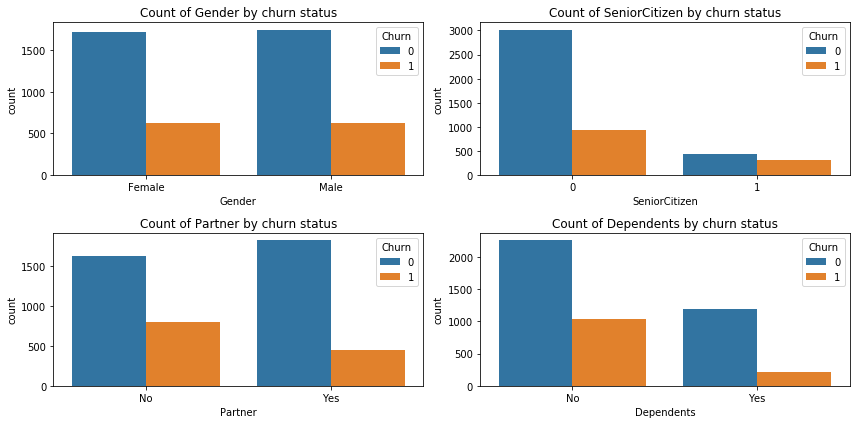

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax = ax.ravel()
demographic_cols = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents']

for i, col in enumerate(demographic_cols):
    sns.countplot(x=col, hue='Churn', data=df_train, ax=ax[i])
    ax[i].set_title('Count of '+col+' by churn status')
plt.tight_layout()
plt.show()

It looks like churn rates are similar across gender; senior users are more likely to churn than non senior users; users without partner or dependents are more likely to churn than those with partner or dependents.

#### Visualize service features

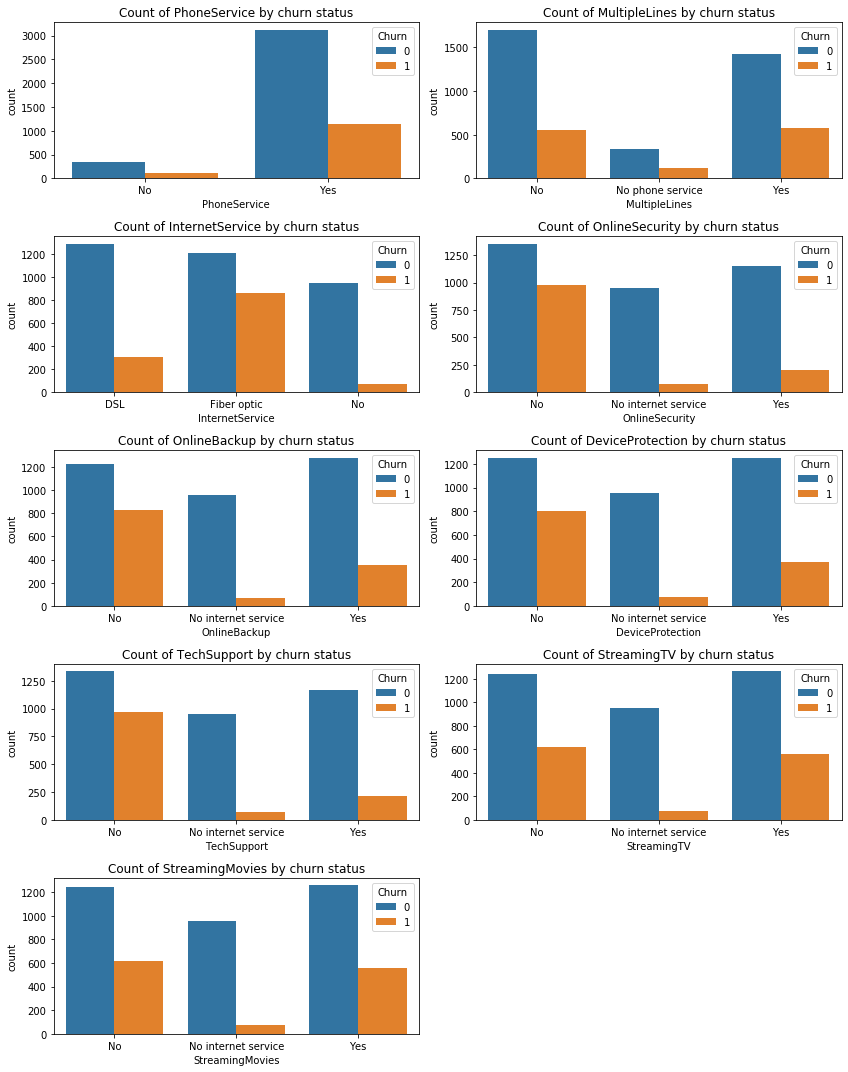

In [9]:
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

fig, ax = plt.subplots(5, 2, figsize=(12, 15))
ax = ax.ravel()
for i, col in enumerate(service_cols):
    sns.countplot(x=col, hue='Churn', data=df_train, ax=ax[i])
    ax[i].set_title('Count of '+col+' by churn status')
plt.tight_layout()
fig.delaxes(ax[9])
plt.show()

#### Visualize customer account features

Categorical account features by churn status

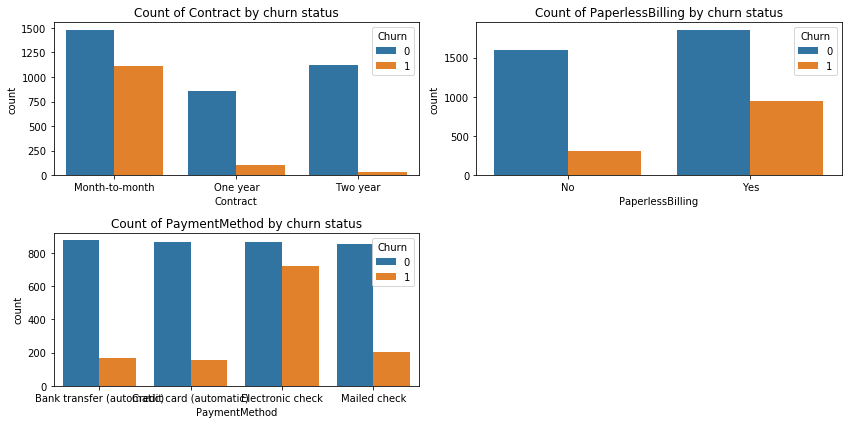

In [10]:
account_cat_cols = [col for col in categorical_cols\
                    if col not in demographic_cols and col not in service_cols]

fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax = ax.ravel()

for i, col in enumerate(account_cat_cols):
    sns.countplot(x=col, hue='Churn', data=df_train, ax=ax[i])
    ax[i].set_title('Count of '+col+' by churn status')
plt.tight_layout()
fig.delaxes(ax[3])
plt.show()

Numeric customer account features
<br> Check distributions of numeric account features to see if log transformation is needed

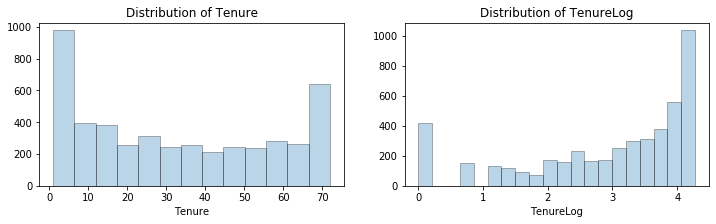

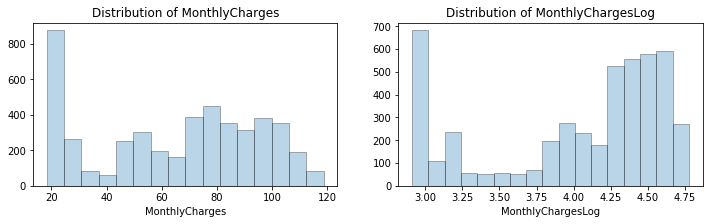

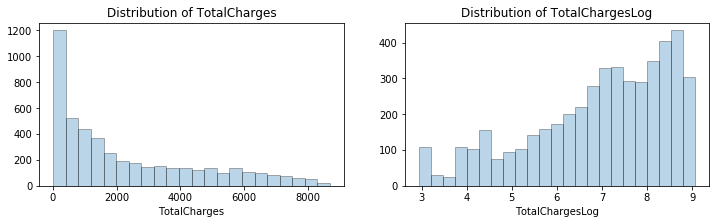

In [11]:
def vis_log_transform(df, column):
    '''plot distribution of an original numerical column and its log transformed values
       column needs to be non-negative
    '''   
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    hist_kws = {'histtype': 'bar', 'edgecolor': 'black', 'alpha': 0.3}
    for i, col in enumerate([column, column+'Log']):
        sns.distplot(df[col], ax=ax[i], hist_kws=hist_kws, kde=False)
        ax[i].set_title('Distribution of '+col)
    plt.show()

for col in numeric_cols:
    df_train[col+'Log'] = df_train[col].apply(np.log)
    vis_log_transform(df_train, col)

Visualize distribution of numeric account features by churn status

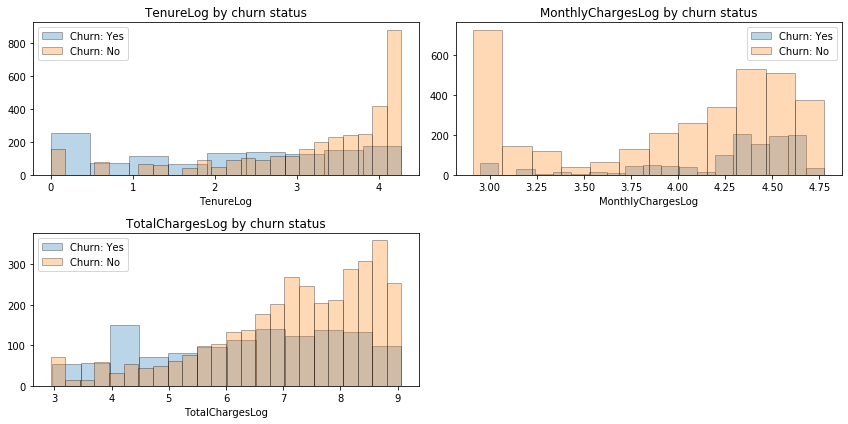

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax = ax.ravel()
hist_kws = {'histtype': 'bar', 'edgecolor': 'black', 'alpha': 0.3}

numeric_log_cols = [col for col in df_train if 'Log' in col]
for i, col in enumerate(numeric_log_cols):
    sns.distplot(df_train[df_train['Churn']==1][col], label='Churn: Yes', 
                 ax=ax[i], hist_kws=hist_kws, kde=False)
    sns.distplot(df_train[df_train['Churn']==0][col], label='Churn: No', 
                 ax=ax[i], hist_kws=hist_kws, kde=False)
    ax[i].set_title(col+' by churn status')
    ax[i].legend()
plt.tight_layout()
fig.delaxes(ax[3])
plt.show()

Visualize mean numeric account features by churn status

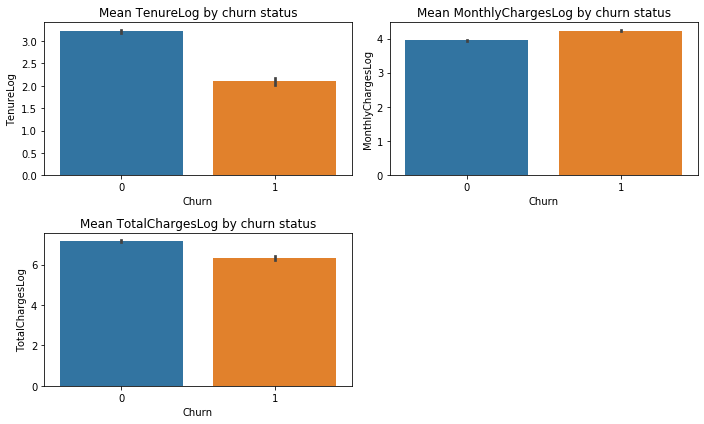

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.ravel()

for i, col in enumerate(numeric_log_cols):
    sns.barplot(x='Churn', y=col, data=df_train, ax=ax[i])
    ax[i].set_title('Mean '+col+' by churn status')
plt.tight_layout()
fig.delaxes(ax[3])
plt.show()

Customers who have churned tend to be newer customers, have slightly higher monthly charges and lower total charges (as a result of low tenure) than customers who have not churned. Although there's quite some overlap in the distributions of these features for churned and not churned customers.

## Modeling

In [94]:
# initiate sampler, specify categorical features
#sampler = SMOTENC(random_state=1, categorical_features=X_train.dtypes=='category')
# fit sampler
#X_train_rs, y_train_rs = sampler.fit_sample(X_train, y_train)

#X_train_rs = pd.DataFrame(X_train_rs, columns=X_train.columns)
# change data types back to those of X_train
#X_train_rs = X_train_rs.astype(X_train.dtypes)

#y_train_rs = pd.Series(y_train_rs)

# check number of samples in original and resampled train data
#print('Number of samples per class in original train data: {}'.format(dict(Counter(y_train))))
#print('Number of samples per class in resampled train data: {}'.format(dict(Counter(y_train_rs))))

### Make custom transformers

In [14]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    '''custom transformer to select columns
    '''
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]

In [15]:
class NumericTransformer(BaseEstimator, TransformerMixin):
    '''custom transformer for numeric columns
    '''
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        '''log transform non negative numeric features
        ''' 
        for col in self.columns:
            X[col] = X[col].apply(np.log)
        return X

In [16]:
# custome transformer for numeric columns
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    '''custom transformer to transform categorical features
    '''
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
      
    def transform(self, X):
        # replace 1/0 with Yes/No for SeniorCitizen to
        # prepare for one hot encoding
        X['SeniorCitizen'] = X['SeniorCitizen'].map({1: 'Yes', 0: 'No'})
        
        # replace no internet service with No for internet related services
        # and no phone service with No for MultipleLines
        internet_service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                                 'TechSupport', 'StreamingTV', 'StreamingMovies']
        X[internet_service_cols] = X[internet_service_cols].replace({'No internet service':
                                                                     'No'})
        X['MultipleLines'] = X['MultipleLines'].replace({'No phone service': 'No'})
        return X

### Make preprocessing pipelines

In [17]:
# exclude PhoneService from categorical features - info in PhoneService 
# is captured in MultipleLines
categorical_features = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents',
                        'MultipleLines', 'InternetService', 'OnlineSecurity',
                        'OnlineBackup', 'DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies', 'Contract',
                        'PaperlessBilling', 'PaymentMethod']
numeric_features = ['Tenure', 'MonthlyCharges', 'TotalCharges']

# make categorical and numeric pipelines
categorical_pl = Pipeline([('categorical selector', ColumnSelector(categorical_features)),
                           ('one hot encoder', OneHotEncoder())])
numeric_pl = Pipeline([('numeric selector', ColumnSelector(numeric_features)),
                       ('numeric transformer', NumericTransformer(numeric_features)),
                       ('scaler', StandardScaler())])

# use feature union to combine categorical and numerical pipelines
preprocessor = FeatureUnion([('categorical preprocessor', categorical_pl),
                             ('numeric preprocessor', numeric_pl)])

### Make full classification pipelines with preprocessor and classifier
To deal with the data imbalance, higher weight will be given to the minority class so that the models will give higher penalties to the minority class. 

In [68]:
# get weight for xgboot
xgb_weight = (y_train==0).sum() / (y_train==1).sum()

# make classifiers dict for all classifiers
# class_weight/scale_pos_weight parameter used to adjust
# weight for minority class
classifiers = {'logistic regression': LogisticRegression(random_state=1,
                                                         max_iter=300,
                                                         class_weight='balanced'),
               'svc (linear kernel)': SVC(kernel='linear',
                                          random_state=1,
                                          probability=True, # to allow calculation of predicted prob
                                          class_weight='balanced'),
               'svc (rbf kernel)': SVC(kernel='rbf',
                                       random_state=1,
                                       probability=True,
                                       class_weight='balanced'),
               'random forest': RandomForestClassifier(random_state=1,
                                                       class_weight='balanced'),
               'xgboost': XGBClassifier(scale_pos_weight=xgb_weight)}

# make pipelines dict
pipelines = {}
for name, classifier in classifiers.items():
    pipelines[name] = Pipeline([('preprocessor', preprocessor),
                                ('classifier', classifier)])

### Fit models with defult parameter settings to benchmark performance

In [69]:
def cv_scores(estimator, X_train, y_train, cv):
    '''fits an estimator and computes cross validation scores,
       returns mean cv accuracy, precision, recall, f1, and roc auc.
    '''
    scores = {}
    cv_results = cross_validate(estimator, X_train, y_train,
                                cv=cv, return_train_score=False,
                                scoring=('accuracy', 'precision',
                                         'recall', 'f1', 'roc_auc'))
    scores['cv_accuracy_mean'] = np.mean(cv_results['test_accuracy'])
    scores['cv_precision_mean'] = np.mean(cv_results['test_precision'])
    scores['cv_recall_mean'] = np.mean(cv_results['test_recall'])
    scores['cv_f1_mean'] = np.mean(cv_results['test_f1'])
    scores['cv_auc_mean'] = np.mean(cv_results['test_roc_auc'])
    return scores

# get cv scores for all classifiers
cv_scores_all = []
for name, pipeline in pipelines.items():
    print('Fitting and cross validating {}...'.format(name))
    scores = cv_scores(pipeline, X_train, y_train, 5)
    cv_scores_all.append(scores)

Fitting and cross validating logistic regression...
Fitting and cross validating svc (linear kernel)...
Fitting and cross validating svc (rbf kernel)...
Fitting and cross validating random forest...
Fitting and cross validating xgboost...


In [70]:
df_cv_scores = pd.DataFrame(cv_scores_all, index=classifiers.keys())
df_cv_scores

,cv_accuracy_mean,cv_precision_mean,cv_recall_mean,cv_f1_mean,cv_auc_mean
logistic regression,0.753133,0.523609,0.801935,0.633469,0.851134
svc (linear kernel),0.718739,0.483847,0.829087,0.610751,0.843706
svc (rbf kernel),0.755468,0.526753,0.791551,0.632525,0.831260
random forest,0.793037,0.648163,0.486422,0.555361,0.825484
xgboost,0.750585,0.520481,0.785957,0.626217,0.845817


Visualize CV scores of default models

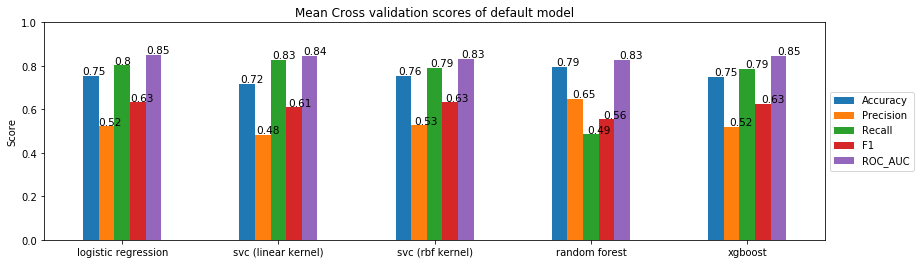

In [41]:
fig, ax = plt.subplots(figsize=(14, 4))
df_cv_scores.plot(kind='bar', ax=ax)
# add scores as annotations
for patch in ax.patches:
    ax.annotate(str(round(patch.get_height(), 2)), (patch.get_x()*1.01, patch.get_height()*1.01),
                fontsize=10.5)
plt.title('Mean Cross validation scores of default model')
plt.ylabel('Score')
plt.ylim((0, 1))
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'],
           loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=0)
plt.show()

Except random forest, the other models have higher recall than precision. In the case of churn prediction, having a high recall and an only acceptable precision would be okay. That is, correct identification of the majority of customers who will actually churn and some false positives of customers who won't actually churn. This is because the cost of not identifying customers who will churn and losing those customers is higher than reaching out to customers who are probably in okay relationship with the company.
<br>In the following section, the models will be tuned to find their optimal hyperparameters.

### Hyperparameter tuning

In [24]:
def tune_hyperparameters(clf_name, estimator, param_grid, n_iter, X_train, y_train, X_test):
    '''tunes hyperparameters of estimator, print best model results,
    and return predictions
    '''
    print('Tuning hyperparameters of {}...'.format(clf_name))
    
    # randomized search cv randomly creates combinations of hyperparameters
    # and uses cross validation to find hyperparameters that give best performance
    rs = RandomizedSearchCV(estimator, param_grid, cv=5,
                            refit='roc_auc', # select model with best auc score
                            scoring=('accuracy', 'precision',
                                     'recall', 'f1', 'roc_auc'),
                            verbose=1, n_jobs=-1, n_iter=n_iter) 
    rs.fit(X_train, y_train)
    y_pred = rs.predict(X_test) # predict test set using the best model from tuning
    
    print('Best parameter set: {}'.format(rs.best_params_))
    print('Mean cv ROC AUC of best model: {:.3f}'.format(rs.best_score_))
    
    return rs, y_pred

#### Tuning logistic regression

In [71]:
# log regression parameter grid
param_grid_lr = {'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0]}
rs_lr, y_pred_lr = tune_hyperparameters(clf_name='logistic regression',
                                        estimator=pipelines['logistic regression'],
                                        param_grid=param_grid_lr, n_iter=10,
                                        X_train=X_train,
                                        y_train=y_train,
                                        X_test=X_test)

Tuning hyperparameters of logistic regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.0s


Best parameter set: {'classifier__penalty': 'l2', 'classifier__C': 1.0}
Mean cv ROC AUC of best model: 0.851


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.6s finished


#### Tuning SVC (linear)

In [72]:
# support vector classifier parameter grid
param_grid_svc = {'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0]}
rs_svc_linear, y_pred_svc_linear = tune_hyperparameters(clf_name='SVC (linear kernel)',
                                                        estimator=pipelines['svc (linear kernel)'],
                                                        param_grid=param_grid_svc, n_iter=5,
                                                        X_train=X_train,
                                                        y_train=y_train,
                                                        X_test=X_test)

Tuning hyperparameters of SVC (linear kernel)...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   29.6s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  8.1min finished


Best parameter set: {'classifier__C': 0.01}
Mean cv ROC AUC of best model: 0.849


#### Tuning SVC (rbf)

In [73]:
param_grid_svc_rbf = {'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0],
                      'classifier__gamma': [0.01, 0.1, 1.0, 10.0, 100.0]}
rs_svc_rbf, y_pred_svc_rbf = tune_hyperparameters(clf_name='SVC (rbf kernel)',
                                                  estimator=pipelines['svc (rbf kernel)'],
                                                  param_grid=param_grid_svc_rbf, n_iter=20,
                                                  X_train=X_train,
                                                  y_train=y_train,
                                                  X_test=X_test)

Tuning hyperparameters of SVC (rbf kernel)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


Best parameter set: {'classifier__gamma': 0.01, 'classifier__C': 1.0}
Mean cv ROC AUC of best model: 0.847


#### Tuning random forest

In [74]:
# hyperparameters to randomly sample from for random forest
param_grid_rf = {'classifier__n_estimators': [100, 200, 400, 800],
                 'classifier__max_depth': [5, 8, 15, 25, 30, None],
                 'classifier__min_samples_split': [2, 5, 10, 15],
                 'classifier__min_samples_leaf': [1, 2, 5, 10]}
rs_rf, y_pred_rf = tune_hyperparameters(clf_name='random forest',
                                        estimator=pipelines['random forest'],
                                        param_grid=param_grid_rf, n_iter=20,
                                        X_train=X_train,
                                        y_train=y_train,
                                        X_test=X_test)

Tuning hyperparameters of random forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.6s finished


Best parameter set: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 10, 'classifier__max_depth': 25}
Mean cv ROC AUC of best model: 0.848


#### Tuning XGBoost

In [33]:
param_grid_xgb = {'classifier__max_depth': [3, 5, 7, 9, 12, 15, 20],
                  'classifier__learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
                  'classifier__n_estimators': [100, 200, 400, 600, 800],
                  'classifier__gamma': [0, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                  'classifier__min_child_weight': [1, 3, 5, 7],
                  'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
                  'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
                  'classifier__reg_alpha': [0, 0.1, 0.5, 1.0],
                  'classifier__reg_lambda': [0.01, 0.1, 1.0]}
rs_xgb, y_pred_xgb = tune_hyperparameters(clf_name='xgboost',
                                          estimator=pipelines['xgboost'],
                                          param_grid=param_grid_xgb, n_iter=20,
                                          X_train=X_train,
                                          y_train=y_train,
                                          X_test=X_test)

Tuning hyperparameters of xgboost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.8s finished


Best parameter set: {'classifier__subsample': 0.7, 'classifier__reg_lambda': 0.01, 'classifier__reg_alpha': 0, 'classifier__n_estimators': 200, 'classifier__min_child_weight': 3, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.025, 'classifier__gamma': 0.7, 'classifier__colsample_bytree': 0.8}
Mean cv ROC AUC of best model: 0.849


#### Get mean cv scores from the best tuned model of each classifier

In [58]:
metrics = ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall',
           'mean_test_f1', 'mean_test_roc_auc']

cv_scores_best_models = []

rs_list = [rs_lr, rs_svc_linear, rs_svc_rbf, rs_rf, rs_xgb]
for rs in rs_list:
    # cv_results__ is a dict with eg params and mean_test_accuracy (of cv)
    # as keys and list/array of results as values, need to get the index of
    # list with the best params and get corresponding test results
    
    idx = rs.cv_results_['params'].index(rs.best_params_)
    cv_scores = {metric:scores[idx] for metric, scores in rs.cv_results_.items() if metric in metrics}
    cv_scores_best_models.append(cv_scores)

df_cv_scores_best_models = pd.DataFrame(cv_scores_best_models,
                                        columns=metrics,
                                        index=list(classifiers.keys()))
df_cv_scores_best_models

,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
logistic regression,0.753133,0.523609,0.801935,0.633469,0.851134
svc (linear kernel),0.744642,0.512510,0.814706,0.629166,0.849034
svc (rbf kernel),0.739970,0.506976,0.811519,0.623994,0.847194
random forest,0.768205,0.546807,0.751605,0.633001,0.849011
xgboost,0.752284,0.522530,0.793141,0.629983,0.849489


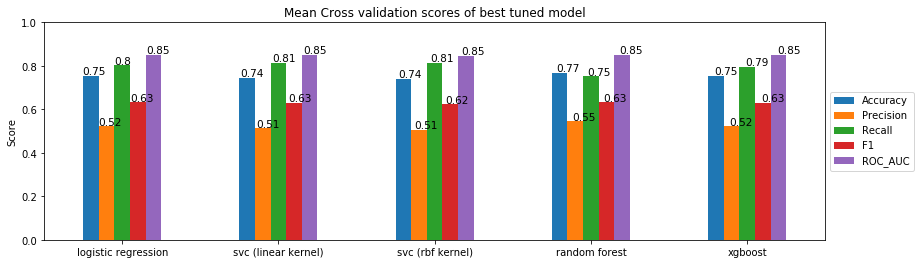

In [37]:
# plot mean cv scores of best tuned model from each classifier
fig, ax = plt.subplots(figsize=(14, 4))
df_cv_scores_best_models.plot(kind='bar', ax=ax)
# add scores as annotations
for patch in ax.patches:
    ax.annotate(str(round(patch.get_height(), 2)), (patch.get_x()*1.01, patch.get_height()*1.01),
                fontsize=10.5)
plt.title('Mean Cross validation scores of best tuned model')
plt.ylabel('Score')
plt.ylim((0, 1))
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'],
           loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=0)
plt.show()

### Model evaluation (on test data)

In [38]:
def holdout_scores(y_pred, y_test):
    '''gets different metric scores for model predictions
       y_pred: array of predicted target values, y_test: array of actual target values
    '''
    test_scores = {}
    test_scores['accuracy'] = accuracy_score(y_test, y_pred)
    test_scores['precision'] = precision_score(y_test, y_pred)
    test_scores['recall'] = recall_score(y_test, y_pred)
    test_scores['f1'] = f1_score(y_test, y_pred)
    test_scores['roc_auc'] = roc_auc_score(y_test, y_pred)
    
    return test_scores

In [39]:
# get test scores for tuned classifiers
y_pred_list = [y_pred_lr, y_pred_svc_linear, y_pred_svc_rbf,
               y_pred_rf, y_pred_xgb]
test_scores_list = []

for y_pred in y_pred_list:
    test_scores = holdout_scores(y_pred, y_test)
    test_scores_list.append(test_scores)

df_test_scores = pd.DataFrame(test_scores_list,
                              index=list(classifiers.keys()))
df_test_scores

,accuracy,precision,recall,f1,roc_auc
logistic regression,0.744938,0.512513,0.829822,0.633663,0.772012
svc (linear kernel),0.720810,0.485053,0.815235,0.608222,0.750927
svc (rbf kernel),0.716502,0.480039,0.799028,0.599757,0.742824
random forest,0.765187,0.540449,0.779579,0.638354,0.769778
xgboost,0.742783,0.510040,0.823339,0.629882,0.768477


Visualize test scores

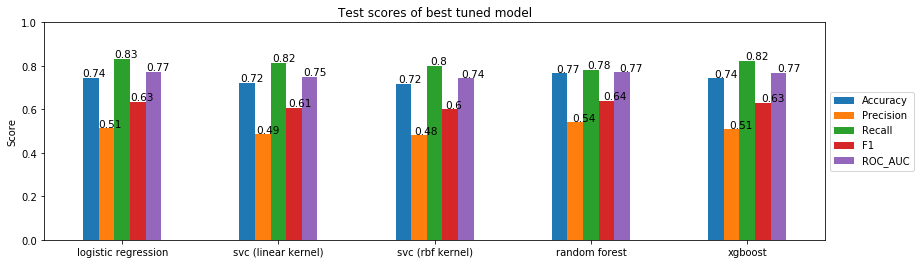

In [43]:
fig, ax = plt.subplots(figsize=(14, 4))
df_test_scores.plot(kind='bar', ax=ax)
# add scores as annotations
for patch in ax.patches:
    ax.annotate(str(round(patch.get_height(), 2)), (patch.get_x()*1.01, patch.get_height()*1.01),
                fontsize=10.5)
plt.title('Test scores of best tuned model')
plt.ylabel('Score')
plt.ylim((0, 1))
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'],
           loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=0)
plt.show()

Logistic regression, random forest and XGBoost perform quite well on the test set and have very similar ROC AUC. Logistic regression and XGBoost also have about the same recall (0.83/0.82) and precision (0.51). Random forest has a slightly lower recall (0.78) and higher precision (0.54). As mentioned, for the problem of churn prediction, a high recall and an okay precision work well. Logistic regression and XGBoost may therefore be preferred. 

#### Plot ROC curves

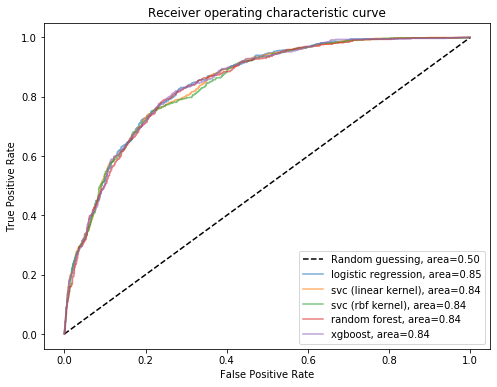

In [93]:
# get y predicted probabilities for all models
y_pred_probs = {}
for clf_name, rs in zip(list(classifiers.keys()), rs_list):
    y_pred_probs[clf_name] = rs.predict_proba(X_test)[:, 1]

# calculate auc, fpr, tpr for all models
auc = {}
fpr = {}
tpr = {}
for clf_name, y_pred_prob in y_pred_probs.items():
    auc[clf_name] = roc_auc_score(y_test, y_pred_prob)
    fpr[clf_name], tpr[clf_name], _ = roc_curve(y_test, y_pred_prob)

fig, ax = plt.subplots(figsize=(8, 6))
# plot roc for random guessing
plt.plot([0, 1], [0, 1], 'k--',
         label='Random guessing, area=0.50')
# iterate over auc, fpr, tpr dictionaries to plot roc for all models
for clf_name in auc.keys():
    plt.plot(fpr[clf_name], tpr[clf_name], alpha=0.6,
             label=clf_name+', area='+str(round(auc[clf_name], 2)))
plt.legend()
plt.title('Receiver operating characteristic curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

The models have rather similar ROC area under curve scores. But as shown in the previous graph, they have slightly different trade-offs between precision and recall.

### Future steps

One future step is to get the importance of features from the classifiers. Important features will then shed light on which aspects of products/services customers might have bad experiences with and should be improved.